In [24]:
import pandas as pd
import scipy.stats as st
import statsmodels.graphics.tsaplots as tg
from statsmodels.tsa.stattools import adfuller
from numpy import log
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split

upload data

In [20]:
df = pd.read_csv('../field8_4Year_time_series.csv')
ts = df['gdd']
len(ts)

1096

## Correlation analisys in time series data

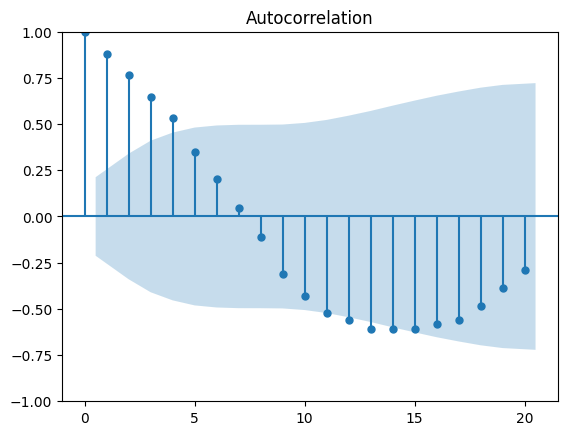

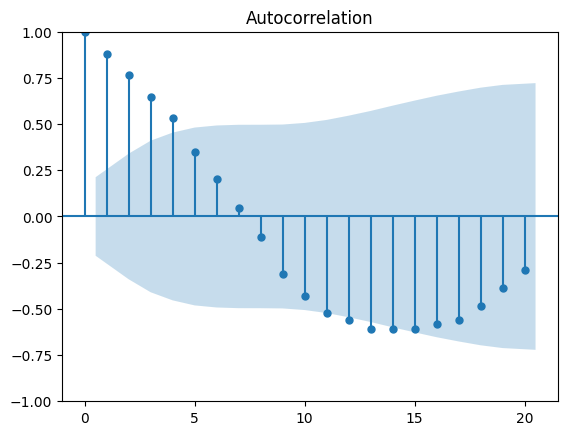

In [10]:
tg.plot_acf(ts)

autocorrelated data

## Sesonality

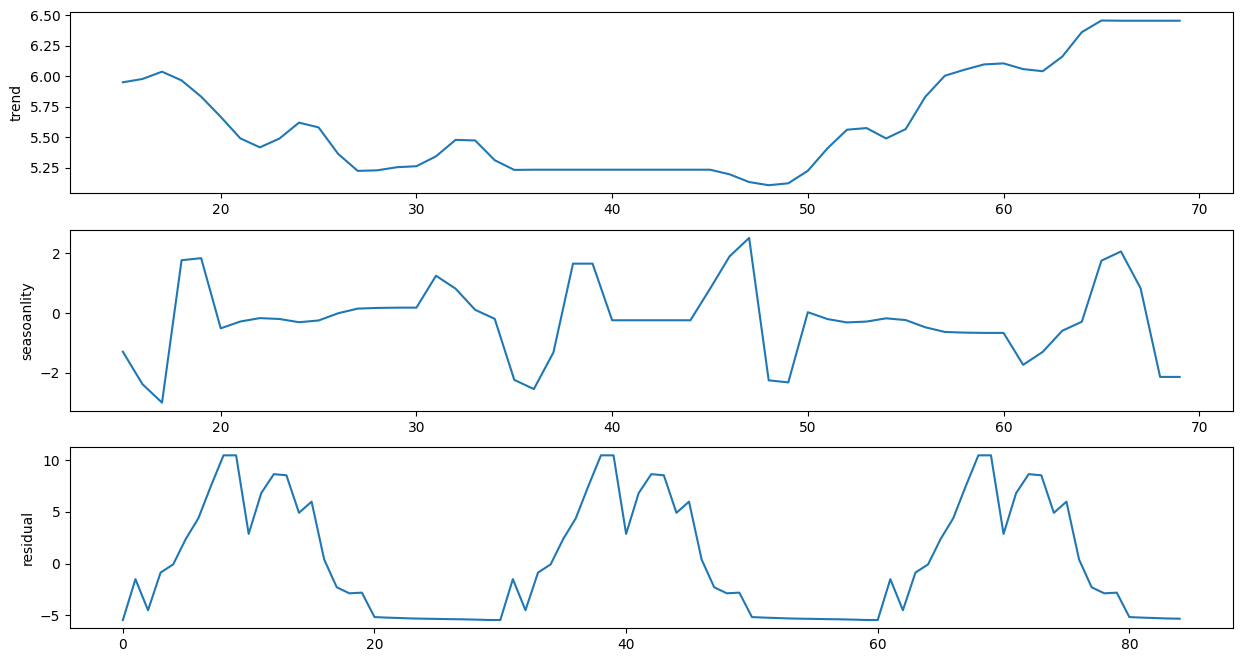

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
res = seasonal_decompose(ts, model = "additive",period = 30)

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
res.trend.plot(ax=ax1,ylabel = "trend")
res.resid.plot(ax=ax2,ylabel = "seasoanlity")
res.seasonal.plot(ax=ax3,ylabel = "residual")
plt.show()

some seasonality in the data

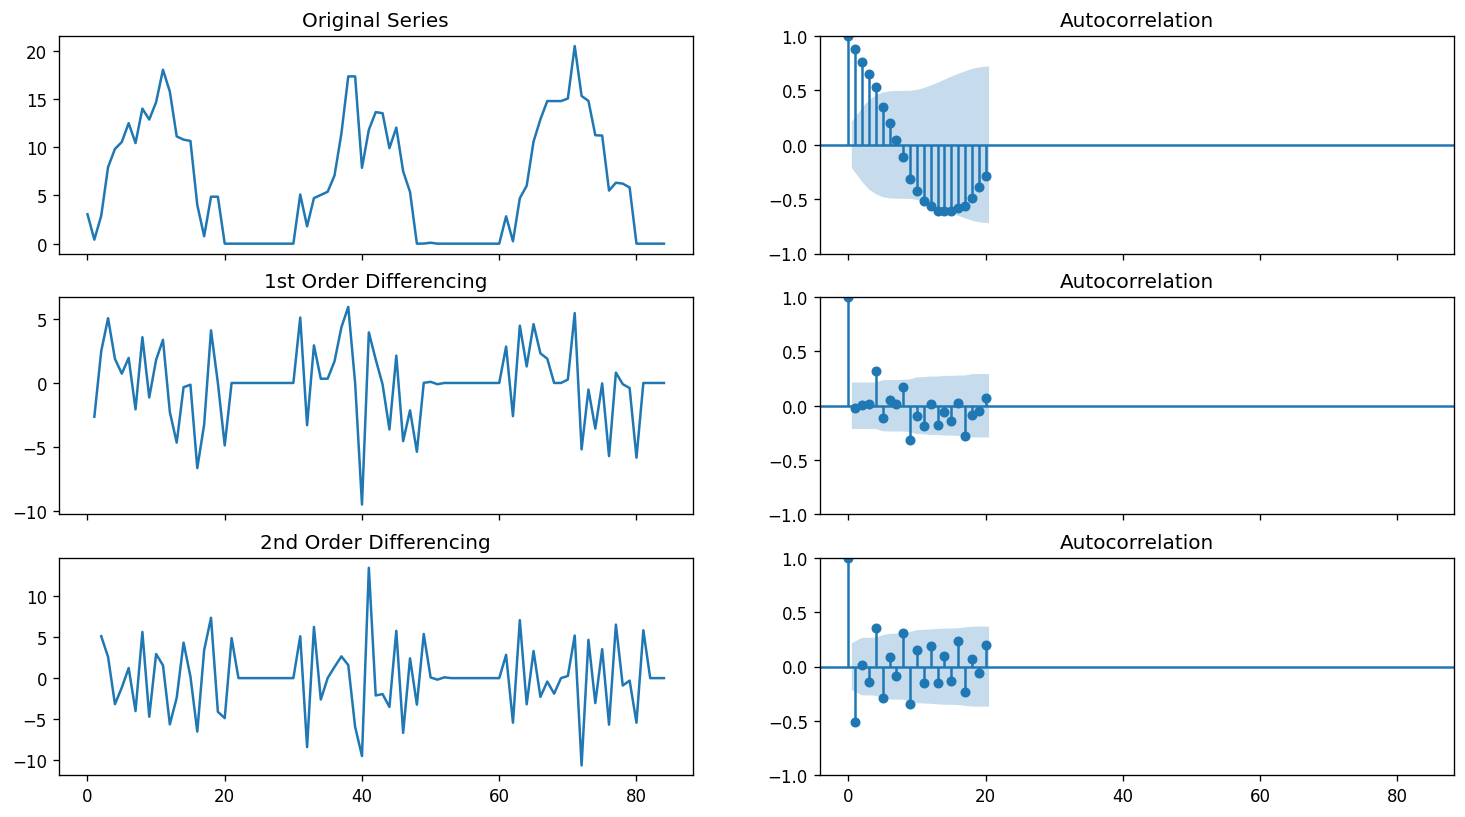

ADF Statistic for 1st Order Differencing
ADF Statistic: -4.279887
p-value: 0.000481
Critical Values:
	1%: -3.523
	5%: -2.902
	10%: -2.588

 ADF Statistic for 2nd Order Differencing
ADF Statistic: -11.776657
p-value: 0.000000
Critical Values:
	1%: -3.515
	5%: -2.898
	10%: -2.586


In [16]:
plt.rcParams.update({'figure.figsize':(15,8), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(ts); axes[0, 0].set_title('Original Series')
tg.plot_acf(ts, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(ts.diff()); axes[1, 0].set_title('1st Order Differencing')
tg.plot_acf(ts.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(ts.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
tg.plot_acf(ts.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

print('ADF Statistic for 1st Order Differencing')
result = adfuller(ts.diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

print('\n ADF Statistic for 2nd Order Differencing')
result = adfuller(ts.diff().diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

time series reachees stationarity after two orders of differencing

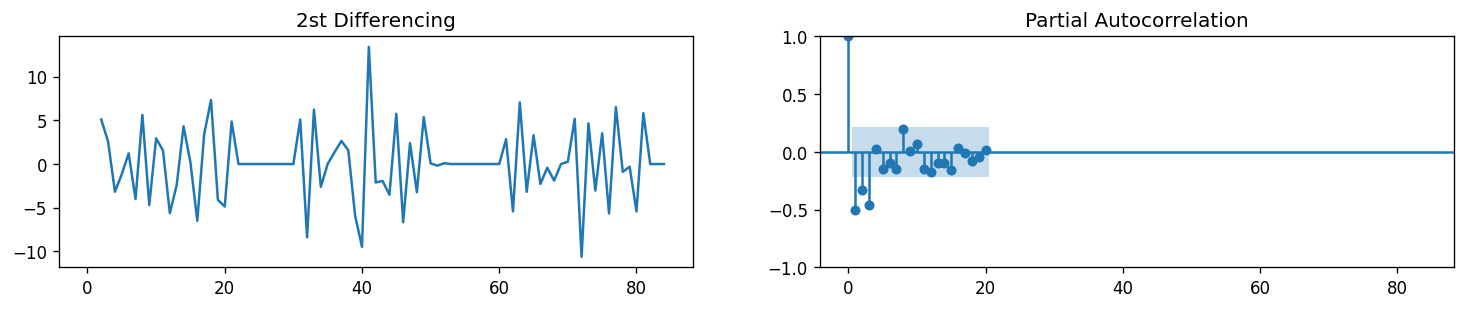

In [17]:
# PACF plot of 2st differenced series
plt.rcParams.update({'figure.figsize':(15,2.5), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(ts.diff().diff()); axes[0].set_title('2st Differencing')
axes[1].set(ylim=(0,5))
tg.plot_pacf(ts.diff().diff().dropna(), ax=axes[1])

plt.show()

PACF returns sigificance at Lag 1, meaning use p=1 for ARIMA model.

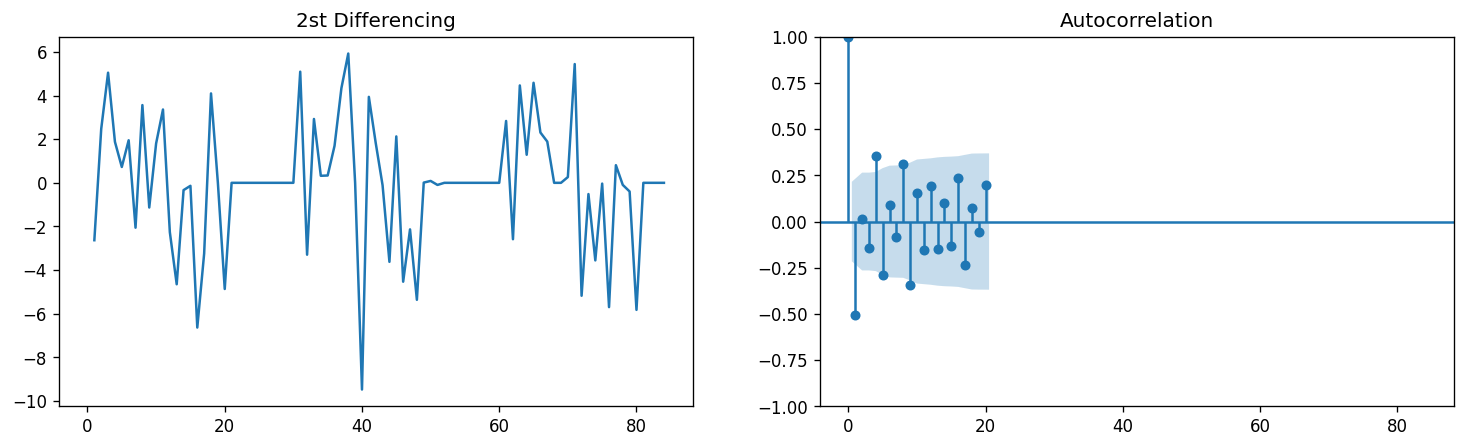

In [18]:
# ACF plot of 2st differenced series
plt.rcParams.update({'figure.figsize':(15,4), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(ts.diff()); axes[0].set_title('2st Differencing')
axes[1].set(ylim=(0,1))
tg.plot_acf(ts.diff().diff().dropna(), ax=axes[1])

plt.show()

 ACF is  comarable with PCF, so use q=1

## Data preprocessing

In [67]:
ts_train = ts.loc[0:950]
ts_test = ts.loc[951:-1]

## Building the ARIMA model

In [73]:
model = ARIMA(ts_train, order=(1,0,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    gdd   No. Observations:                  951
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1695.074
Date:                Sat, 11 Nov 2023   AIC                           3398.147
Time:                        09:01:32   BIC                           3417.577
Sample:                             0   HQIC                          3405.550
                                - 951                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.6672      2.525      2.245      0.025       0.719      10.616
ar.L1          0.9840      0.007    133.849      0.000       0.970       0.998
ma.L1         -0.2620      0.026    -10.255      0.0

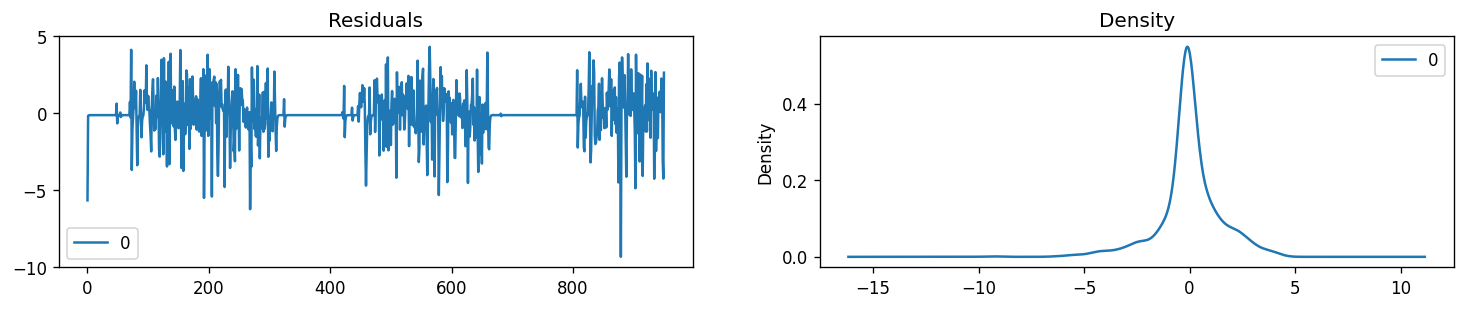

In [74]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2, figsize=(15,2.5))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

The residual errors should be a Gaussian with a zero mean and uniform variance. With this can now proceed with fitting our initial time series with our model.

C:\Users\thoma\AppData\Local\Temp\ipykernel_10252\3502520460.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


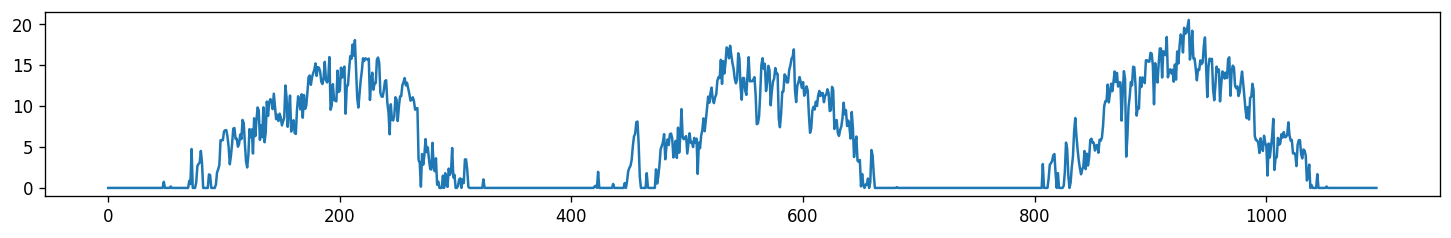

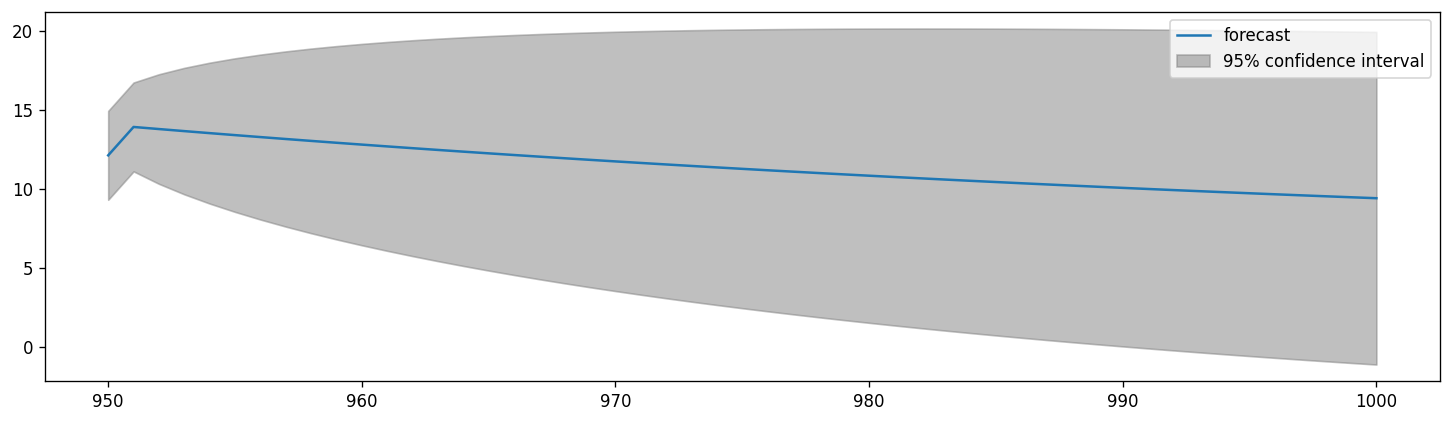

In [78]:
fig, ax = plt.subplots(figsize=(15,2))
ax = ts.plot(ax=ax)
fig = plot_predict(model_fit,start=950,end=1000, dynamic=False)
fig.show()

In [76]:
model_fit.save('gdd_forecast_arima', remove_data=False)